In [24]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as crs
import cartopy
from cmocean import cm
import os
import regionmask
from datetime import datetime as dt

from Functions import * 
from combine_data import *
import pandas as pd

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

In [3]:
#Read sources
folder = "../Pakistan/"
combined_sources = read_data_pakistan(folder)



In [41]:
def read_precipitation_ERA5(variable, datetime):
    """Load data for given variable and date."""
    template = "../Pakistan/ERA5/ERA5_{year}-{month:02d}-{day:02d}_{variable}.nc"

    # Load data
    filepath = template.format(
        year=datetime.year,
        month=datetime.month,
        day=datetime.day,
        hour=datetime.hour,
        minute=datetime.minute,
        variable=variable,
    )
    da = xr.open_dataarray(filepath).sel(time=datetime.strftime("%Y%m%d%H%M"))

    if "lev" in da.coords:
        da = da.rename(lev="level")

    # If it's 4d data we want to select a subset of the levels
    if variable in ["u", "v", "q"] and isinstance(config.levels, list):
        return da.sel(level=config.levels)

    return da

def read_tracmass_precip(basedir):
    """Read tracmass data.

    Data supplied by Dipanjan Dey
    Units in mm/day, so multiplied with # of event days.
    """
    nrdays = 15
    path = basedir / "results TRACMASS Dipanjan Dey"

    ds = xr.open_dataset(
        path / "TRACMASS_diagnostics.nc"
    )  # Evaporative sources (and preicp?) mm/day

    # Not used, but good to know it's available.
    ds_pr_TRACMASS = xr.open_dataset(
         path / "PR_ERA5_TRACMASS.nc"
     )  # Precip ERA5 and TRACMASS Comparison

    # convert to -180 to 180 lon
    ds.coords["lon"] = (ds.coords["lon"] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)

    # Units of data is mm/day but we want mm over whole time period
    return ds["P_TRACMASS"].rename("TRACMASS") * nrdays

In [36]:
precip_dt = pd.date_range(
        start=dt(2022,8,10,1),
        end=dt(2022,8,25,0),
        freq="1h",
    )

precip_event = 0
for i in range(len(precip_dt)):
    precip_event += read_precipitation_ERA5("tp",precip_dt[i])*1000.0

In [47]:
def read_precipdata_pakistan(basedir):
    """Examples of data loading of moisture sources

    Data is loaded per individual ensemble member for each model.
    All data is converted to mm evaporative sources over the whole time period

    # TODO: I think this comment is outdated, right?
    WRF-WVT is not included yet, as well CHc Lagranto and univie FLEXPART

    There might also be a few (new) ensemble members not included yet:
    - For the HAMSTER model (Ughent) there is an additional ensemble member not included yet
    - Extra ensemble members of Flexpart-Watersip produced by Fandy
    """
    # Combine cumulative moisture sources for all models in one netcdf
    basedir = Path(basedir)

    return xr.merge(
        [
            #read_2ldrm(basedir),
            #read_flexpart_uib(basedir),
            #read_lagranto_chc(basedir),
            #read_flexpart_xu(basedir),
            #read_flexpart_tatfancheng(basedir),
            read_tracmass_precip(basedir),
            ##read_ughent(basedir),
            ##read_utrack(basedir),
            #read_uvigo(basedir),
            ##read_wam2layers(basedir),
        ]
    )


In [48]:
Precip_cases = read_precipdata_pakistan("../Pakistan")



(24.0, 32.0)

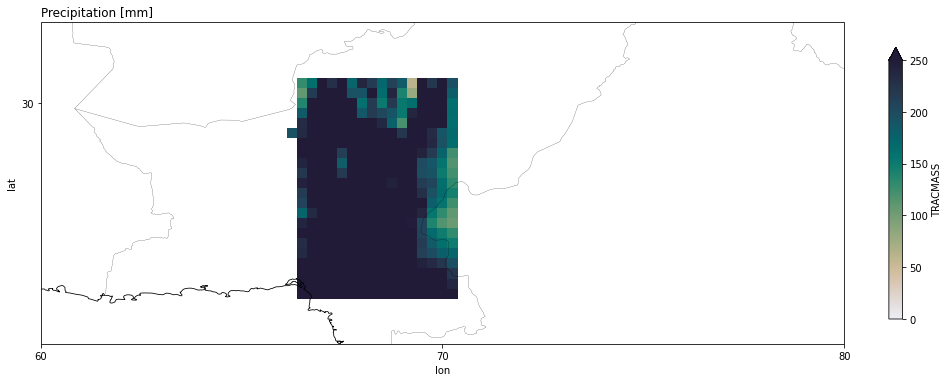

In [53]:

# Make sample figure (in this case of WAM2layers)
my_projection = crs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection=crs.PlateCarree())

Precip_cases["TRACMASS"].plot(
        vmin=0, #Min source in mm
        vmax=250, #Max source in mm
        robust=False,
        cmap=cm.rain, #Colour map from cmocean package
        cbar_kwargs=dict(fraction=0.05, shrink=0.5),
    )

ax.set_title("Precipitation [mm]", loc="left")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax.set_xlim(60, 80) #Setting limits in longitude dimension
ax.set_ylim(24, 32) #Setting limits in latitude dimension

(-40.0, 50.0)

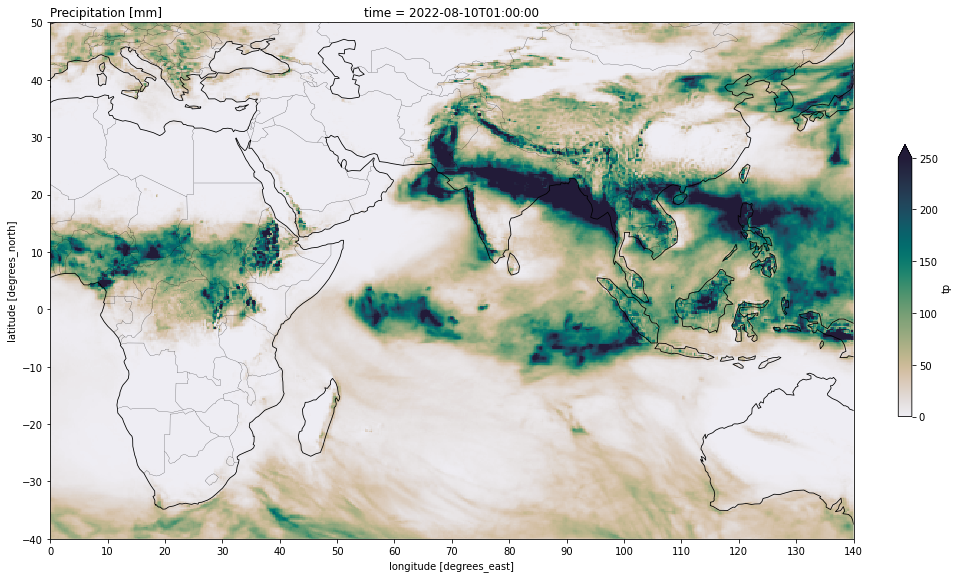

In [39]:
# Make sample figure (in this case of WAM2layers)
my_projection = crs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection=crs.PlateCarree())

precip_event.plot(
        vmin=0, #Min source in mm
        vmax=250, #Max source in mm
        robust=False,
        cmap=cm.rain, #Colour map from cmocean package
        cbar_kwargs=dict(fraction=0.05, shrink=0.5),
    )

ax.set_title("Precipitation [mm]", loc="left")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax.set_xlim(0, 140) #Setting limits in longitude dimension
ax.set_ylim(-40, 50) #Setting limits in latitude dimension